In [8]:
"""
Construct a real HDF5 file from the real dataset (RT-1-X)
"""

#load the dataset
import os
os.environ['CURL_CA_BUNDLE'] = '/etc/ssl/certs/ca-bundle.crt'
import tensorflow as tf 
import tensorflow_datasets as tfds
import tqdm
import h5py
import numpy as np
# load raw dataset --> replace this with tfds.load(<dataset_name>) on your
# local machine!
# dataset_name = 'bc_z'
dataset_name_list = ['fractal20220817_data',
'bridge:1.0.0',
'taco_play',
'jaco_play',
'roboturk',
'viola',
'berkeley_autolab_ur5',
'language_table',
'stanford_hydra_dataset_converted_externally_to_rlds',
'maniskill_dataset_converted_externally_to_rlds',
'ucsd_kitchen_dataset_converted_externally_to_rlds',
'ucsd_pick_and_place_dataset_converted_externally_to_rlds',
'bc_z',
'berkeley_rpt_converted_externally_to_rlds',
'kaist_nonprehensile_converted_externally_to_rlds',
'stanford_mask_vit_converted_externally_to_rlds',
'asu_table_top_converted_externally_to_rlds',
'stanford_robocook_converted_externally_to_rlds',
'iamlab_cmu_pickup_insert_converted_externally_to_rlds',
'berkeley_fanuc_manipulation',
'cmu_food_manipulation',
'cmu_play_fusion',
'berkeley_gnm_recon']


data_dir= '/data/home/acw694/CLIPort_new_loss/scratch/tensorflow_datasets'

# Take just take the first and the last step
def episode2steps(episode):
    return episode['steps']

def filter_first_last_terminal(step):
    return step['is_first'] | step['is_terminal']

def append_or_create_dataset(f, name, data, dtype=None):

    if name in f:
        # If dataset already exists, append to it
        dset = f[name]
        dset.resize(dset.shape[0] + len(data), axis=0)
        dset[-len(data):] = data
        n = len(dset)

    else:
        if dtype is None:
            maxshape = (None,) + data[0].shape
            chunks = (1,) + data[0].shape
            f.create_dataset(name, data=data, maxshape=maxshape,
                                chunks=chunks)
        else:
            maxshape = (None,)
            chunks = (1,)  # For variable-length data
            f.create_dataset(name, data=data, maxshape=maxshape,
                                chunks=chunks, dtype=dtype)

        n = len(data)

    return n

In [126]:
import matplotlib.pyplot as plt
import tensorflow as tf

dataset_name =  dataset_name_list[-2]

# load the dataset
ds, ds_info = tfds.load(
    dataset_name, data_dir = data_dir, download=False, split='train', with_info=True)

print(ds_info)

def step_map_fn(step):
    return {
        'observation': {
            'image': step['observation']['image_0'],
            'language': step['language_instruction'],
        }   
    }

tfds.core.DatasetInfo(
    name='cmu_play_fusion',
    full_name='cmu_play_fusion/0.1.0',
    description="""
    The robot plays with 3 complex scenes: a grill with many cooking objects like toaster, pan, etc. It has to pick, open, place, close. It  has to set a table, move plates, cups, utensils. And it has to place dishes in the sink, dishwasher, hand cups etc.
    """,
    homepage='https://play-fusion.github.io/',
    data_dir='/data/home/acw694/CLIPort_new_loss/scratch/tensorflow_datasets/cmu_play_fusion/0.1.0',
    file_format=tfrecord,
    download_size=Unknown size,
    dataset_size=6.68 GiB,
    features=FeaturesDict({
        'episode_metadata': FeaturesDict({
            'file_path': Text(shape=(), dtype=string),
        }),
        'steps': Dataset({
            'action': Tensor(shape=(9,), dtype=float32),
            'discount': Scalar(shape=(), dtype=float32),
            'is_first': bool,
            'is_last': bool,
            'is_terminal': bool,
            'languag

In [124]:
print(f"Loading dataset: {dataset_name}")
data_s1 = []
data_s2 = []
data_language = []

# first map to steps
ds_steps = ds.map(
    episode2steps, num_parallel_calls=tf.data.AUTOTUNE).flat_map(lambda x: x)

# then filtered out the first and the last image
filtered_ds = ds_steps.filter(filter_first_last_terminal)

# obtain the image in each step
ds_mapped = filtered_ds.map(step_map_fn, num_parallel_calls=tf.data.AUTOTUNE)
batch_itor = ds_mapped.batch(2).as_numpy_iterator()


Loading dataset: bridge:1.0.0


b'put small spoon from basket to tray'
b'put small spoon from basket to tray'


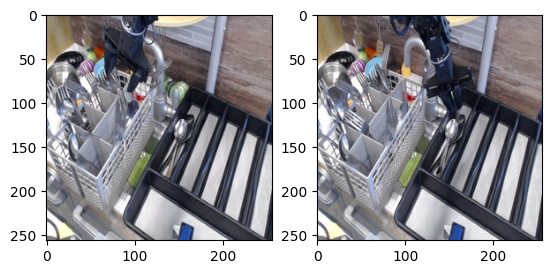

In [125]:
batch = next(batch_itor)
# Collect images and language data
image_start = batch['observation']['image'][0]
image_end = batch['observation']['image'][1]

plt.subplot(1, 2, 1)
plt.imshow(image_start)
plt.subplot(1, 2, 2)
plt.imshow(image_end)
language_start = batch['observation']['language'][0]
language_end = batch['observation']['language'][1]

print(language_start)
print(language_end)

#assert image_start.shape == image_end.shape
#assert language_start == language_end, "Language should be the same for the first and last step"

In [127]:
image_end.shape

(256, 256, 3)